# Project Scope and Description

What is the problem?

For this project we are tasked with implementing a convolutional neural network for a binary image classification problem. The images at hand are small image patches taken from larger digital pathology scans. The goal is to detect and identify metastatic cancer. A difficulty we will face when implementing the algorithm is the amount of variation we have in the metastases. They can be as small as single cells in a large area of tissue.

What data do we have available?

There is a total of 220,000 training images and 57,000 testing images. 

Based the data, there is a 40/60 balance between positive and negative examples in the training set. A positive label means that there is at least one pixel of tumor tissue in the center region (32 x 32px) of the image. Tumor tissue in the outer region of the patch do not influence the label.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil

from PIL import Image

Now lets create the labeled dataframe

In [2]:
data = pd.read_csv('../desktop/_labels.csv')

## Exploratory Data Analysis

In [3]:
data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
data.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [5]:
data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

What do these images look like?

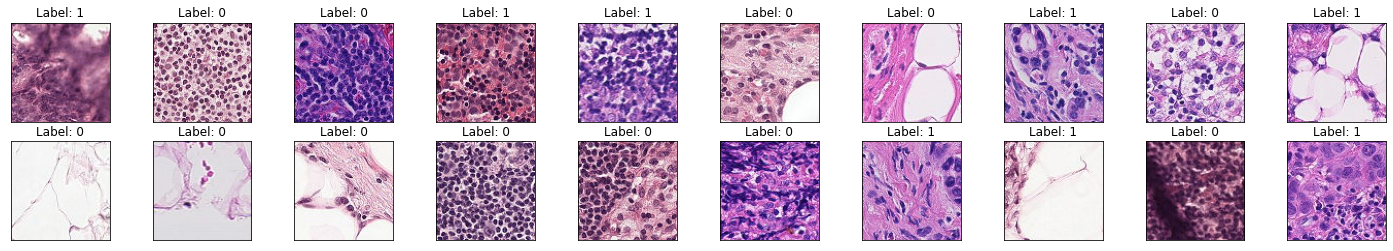

In [6]:
fig = plt.figure(figsize=(25, 4))
# display 20 images
train_imgs = os.listdir("../desktop/train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("../desktop/train/" + img)
    plt.imshow(im)
    lab = data.loc[data['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [7]:
from glob import glob

In [8]:
labeled_files = glob('../desktop/train/*.tif')
test_files = glob('../desktop/test/*.tif')

In [9]:
print("labeled_files size :", len(labeled_files))
print("test_files size :", len(test_files))

labeled_files size : 220025
test_files size : 57458


Next lets see if there are any really dark or light images. We will not necessarily remove these, but it is good information to have

In [10]:
from tqdm import tqdm_notebook

In [11]:
DB_PATH   = r'../desktop/'
TRAIN_DIR = r'../desktop/train/'
TEST_DIR  = r'../desktop/test/'
DIR       = ['train/', 'test/']

In [12]:
data.id = data.id + '.tif'

In [13]:
data.dtypes

id       object
label     int64
dtype: object

In [14]:
import os, warnings, random, time, multiprocessing, pickle
from skimage.io import imread

In [15]:
# # Check for any completely black or white images

dark_th = 10 / 255                             # If no pixel reaches this threshold, image is considered too dark
bright_th = 245 / 255                          # If no pixel is under this threshold, image is considerd too bright
too_dark_idx = []
too_bright_idx = []

x_tot = np.zeros(3)
x2_tot = np.zeros(3)
counted_ones = 0

for i, idx in tqdm_notebook(enumerate(data['id']), 'Computing...(220.025 total files)'):
     path = os.path.join(TRAIN_DIR, idx)
     imagearray = imread(path).reshape(-1,3)
    
     if((imagearray.max() / 255) < dark_th):            # is this too dark
         too_dark_idx.append(idx)
         continue                                       # do not include in statistics
    
     if((imagearray.min() / 255) > bright_th):          # is this too bright
         too_bright_idx.append(idx)
         continue                                       # do not include in statistics

print('There was {0} extremely dark image'.format(len(too_dark_idx)))
print('and {0} extremely bright images'.format(len(too_bright_idx)))
print('Dark one:')
print(too_dark_idx)
print('Bright ones:')
print(too_bright_idx)

<ipython-input-15-2458ff264092>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, idx in tqdm_notebook(enumerate(data['id']), 'Computing...(220.025 total files)'):


Computing...(220.025 total files): 0it [00:00, ?it/s]

There was 1 extremely dark image
and 6 extremely bright images
Dark one:
['9369c7278ec8bcc6c880d99194de09fc2bd4efbe.tif']
Bright ones:
['9071b424ec2e84deeb59b54d2450a6d0172cf701.tif', 'f6f1d771d14f7129a6c3ac2c220d90992c30c10b.tif', '5f30d325d895d873d3e72a82ffc0101c45cba4a8.tif', '54df3640d17119486e5c5f98019d2a92736feabc.tif', '5a268c0241b8510465cb002c4452d63fec71028a.tif', 'c448cd6574108cf14514ad5bc27c0b2c97fc1a83.tif']


It looks like this only consists of 7 images. One that is too dark and another 6 that are too light. Let's visualize these now.

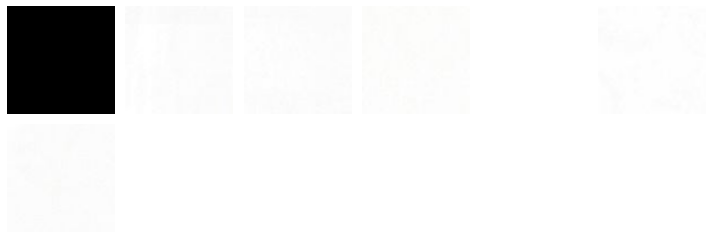

In [16]:
unusable = too_dark_idx + too_bright_idx

plt.figure(figsize=(10,10))
i = 0
for n in unusable:
    img = imread(TRAIN_DIR + n)
    plt.subplot(6,6,i+1)
    plt.imshow(img) 
    plt.axis('off')
    i = i+1
    plt.tight_layout()
plt.show()

Based on the sheer size of the dataset, it is probably not worth taking these outliers out. They should have no change on the performance of the model.

Splitting into training and testing set

In [15]:
base_tile_dir = '../desktop/train/'
df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.tif'))})

In [16]:
labels = pd.read_csv("../desktop/_labels.csv")

In [17]:
df['id'] = df.path.map(lambda x: ((x.split("/")[2].split('.')[0])[6:]))

In [18]:
df

,path,id
0,../desktop/train\00001b2b5609af42ab0ab276dd4cd...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5
1,../desktop/train\000020de2aa6193f4c160e398a8ed...,000020de2aa6193f4c160e398a8edea95b1da598
2,../desktop/train\00004aab08381d25d315384d646f5...,00004aab08381d25d315384d646f5ce413ea24b1
3,../desktop/train\0000d563d5cfafc4e68acb7c98292...,0000d563d5cfafc4e68acb7c9829258a298d9b6a
4,../desktop/train\0000da768d06b879e5754c43e2298...,0000da768d06b879e5754c43e2298ce48726f722
...,...,...
220020,../desktop/train\fffe6c73afcf5f5da5818fb70cb72...,fffe6c73afcf5f5da5818fb70cb723026b172eca
220021,../desktop/train\fffeb3f5361ea57e728fb689e6be3...,fffeb3f5361ea57e728fb689e6be34d07d16ca7e
220022,../desktop/train\fffeca85b16452a7709d163e05a70...,fffeca85b16452a7709d163e05a70e646782b3cc
220023,../desktop/train\fffeeb1297fd4e26f247af648a2a6...,fffeeb1297fd4e26f247af648a2a6f942dfa2e9d


In [19]:
df = df.merge(labels, on = "id")

In [20]:
df

,path,id,label
0,../desktop/train\00001b2b5609af42ab0ab276dd4cd...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,../desktop/train\000020de2aa6193f4c160e398a8ed...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,../desktop/train\00004aab08381d25d315384d646f5...,00004aab08381d25d315384d646f5ce413ea24b1,0
3,../desktop/train\0000d563d5cfafc4e68acb7c98292...,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
4,../desktop/train\0000da768d06b879e5754c43e2298...,0000da768d06b879e5754c43e2298ce48726f722,1
...,...,...,...
220020,../desktop/train\fffe6c73afcf5f5da5818fb70cb72...,fffe6c73afcf5f5da5818fb70cb723026b172eca,0
220021,../desktop/train\fffeb3f5361ea57e728fb689e6be3...,fffeb3f5361ea57e728fb689e6be34d07d16ca7e,0
220022,../desktop/train\fffeca85b16452a7709d163e05a70...,fffeca85b16452a7709d163e05a70e646782b3cc,1
220023,../desktop/train\fffeeb1297fd4e26f247af648a2a6...,fffeeb1297fd4e26f247af648a2a6f942dfa2e9d,1


In [21]:
# taking 10000 sample so our model run faster (experimentation)

from sklearn.model_selection import train_test_split

df_new = df.sample(n=10000, random_state=2018)

train, valid = train_test_split(df_new,test_size=0.2)

In [22]:
# taking 120000 sample for our ResNet Model

from sklearn.model_selection import train_test_split

df_new = df.sample(n=120000, random_state=2018)

train1, valid1 = train_test_split(df_new,test_size=0.2)

In [23]:
train

,path,id,label
63745,../desktop/train\4a86f2cb6bf3f7eb4d3c22e9962f6...,4a86f2cb6bf3f7eb4d3c22e9962f6705fcf125ab,1
113762,../desktop/train\84b43635c43104576f58c061b22fb...,84b43635c43104576f58c061b22fb3e413cada77,0
83592,../desktop/train\619527f6891c9cfbc9070f6f1d8ac...,619527f6891c9cfbc9070f6f1d8ac79be64be1e1,0
198142,../desktop/train\e6b3a6d6630234134447b9cf6df70...,e6b3a6d6630234134447b9cf6df705154a574498,1
159498,../desktop/train\b9f830f9f789748cbe3d83b56e69b...,b9f830f9f789748cbe3d83b56e69bcb1ee019327,1
...,...,...,...
30384,../desktop/train\239e6c7942452a45d1ee37ffd5e66...,239e6c7942452a45d1ee37ffd5e6640ba0d591e3,0
177767,../desktop/train\cf36e5f1f58d344d1f3ee72f56df3...,cf36e5f1f58d344d1f3ee72f56df3276debefc3d,1
62660,../desktop/train\493fdc7cf4cc656809a8ad11179e4...,493fdc7cf4cc656809a8ad11179e4a0199ff39a8,1
184145,../desktop/train\d690c3c799dd7128c4bd4c77c5e33...,d690c3c799dd7128c4bd4c77c5e3311b0778f15d,0


In [24]:
train['label'].value_counts()

0    4771
1    3229
Name: label, dtype: int64

In [25]:
train['label'] = train['label'].astype('str')

In [26]:
valid['label'] = valid['label'].astype('str')

In [27]:
train1

,path,id,label
197318,../desktop/train\e5c79d989cd559229a3505cc7b16a...,e5c79d989cd559229a3505cc7b16a8f7b68b659c,1
5619,../desktop/train\06867d46fa0c930dfd3697a3cbe38...,06867d46fa0c930dfd3697a3cbe38480ae8b3018,0
37761,../desktop/train\2c32dddf036273dd3be18de93df4e...,2c32dddf036273dd3be18de93df4e3df1133735d,0
212070,../desktop/train\f6b6ac6aaae3373652c279849c4fa...,f6b6ac6aaae3373652c279849c4fa94904a9599c,1
154913,../desktop/train\b48170c193d8833f948eb1821fcd6...,b48170c193d8833f948eb1821fcd68fcb864ec5d,1
...,...,...,...
97886,../desktop/train\726ab3fb4a5a4f378dd0b5645df97...,726ab3fb4a5a4f378dd0b5645df977163f4b6eb2,0
90046,../desktop/train\692dbb6d50835bfc09449b049a182...,692dbb6d50835bfc09449b049a1828e6815bd572,0
43180,../desktop/train\32827279d450664c2a21b53794483...,32827279d450664c2a21b53794483b69d4d8a301,0
137380,../desktop/train\a0004fc1b8a1469913349b5a03b06...,a0004fc1b8a1469913349b5a03b0663222edbde3,1


In [29]:
train1['label'].value_counts()

0    57165
1    38835
Name: label, dtype: int64

In [30]:
train1['label'] = train1['label'].astype('str')

<ipython-input-30-08adb2d9968f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1['label'] = train1['label'].astype('str')


In [31]:
valid1['label'] = valid1['label'].astype('str')

<ipython-input-31-39b55f0e327f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid1['label'] = valid1['label'].astype('str')


In [32]:
datagen = ImageDataGenerator(rescale=1.0/255)

In [33]:
train_generator = datagen.flow_from_dataframe(dataframe = train, 
                                                    directory = None,
                                                    x_col = 'path', 
                                                    y_col = 'label',
                                                    target_size = (96,96),
                                                    class_mode = "binary",
                                                    batch_size=32,
                                                    seed = 110318,
                                                    shuffle = True)

Found 8000 validated image filenames belonging to 2 classes.


In [34]:
valid_generator = datagen.flow_from_dataframe(dataframe = valid,
                                                   directory = None,
                                                   x_col = 'path',
                                                   y_col = 'label',
                                                   target_size = (96,96),
                                                   class_mode = 'binary',
                                                   batch_size = 32,
                                                   shuffle = False)

Found 2000 validated image filenames belonging to 2 classes.


In [35]:
train_generator1 = datagen.flow_from_dataframe(dataframe = train1, 
                                                    directory = None,
                                                    x_col = 'path', 
                                                    y_col = 'label',
                                                    target_size = (96,96),
                                                    class_mode = "binary",
                                                    batch_size=32,
                                                    seed = 110318,
                                                    shuffle = True)

Found 96000 validated image filenames belonging to 2 classes.


In [36]:
valid_generator1 = datagen.flow_from_dataframe(dataframe = valid1,
                                                   directory = None,
                                                   x_col = 'path',
                                                   y_col = 'label',
                                                   target_size = (96,96),
                                                   class_mode = 'binary',
                                                   batch_size = 32,
                                                   shuffle = False)

Found 24000 validated image filenames belonging to 2 classes.


### EDA Conclusions

Our data really did not need much done to it in terms of cleaning and preprocessing. The positive to negative ratio was left untouched, because although there were more negatives than positives, this is reflective of a real world population. We were also able to see what a negative and positive image actually looked like. Truthfully, to the naked eye it was very hard to tell the difference. Lastly we were able to detect a few outliers and split our training data into a training set and validation set.

## Model Architecture

What model architecture are we using and why?

We will be using the ResNet CNN model as our official model, but are also using a manually made simple 3 filter CNN as a baseline model to compare to. The trainable parameters for the simpler model are 1.6 million and for the ResNet 28.3 million parameters. The ResNet model is a relatively new model that overcame the vanishing gradient problem. This had been a major issue in the past with deep neural networks. As mentioned in class, the ResNet avoids this by introducing the identity shortcut connection that can skip one or more layers. We will be compiling using the 'adam' optimizer, because of its success rate on noisy data as compared to stochastic gradient descent. For both the baseline algorithm and ResNet CNN I will be implementing early stopping that will monitor validation loss as well as "reduce lr" that will help to adjust the learning rate as the learning progresses. This is an extremely complex and large dataset, so I believe the ResNet will prove far superior.

In [37]:
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from keras.layers import Input

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D


In [43]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "softmax"))

model.compile(loss = 'binary_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 conv2d_10 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 45, 45, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 43, 43, 64)        18496     
                                                      

In [53]:
earlystopping1 = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=8
                             )
checkpointer1 = ModelCheckpoint(filepath="clf-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr1 = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=5,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer1, earlystopping1, reduce_lr1]

In [45]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=5,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

In [46]:
h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 25, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.4036
Epoch 00001: val_loss improved from inf to 0.66384, saving model to clf-weights.hdf5
250/250 [==============================] - 147s 584ms/step - loss: 0.6777 - accuracy: 0.4036 - val_loss: 0.6638 - val_accuracy: 0.4234
Epoch 2/25
250/250 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.4036
Epoch 00002: val_loss did not improve from 0.66384
250/250 [==============================] - 149s 596ms/step - loss: 0.6758 - accuracy: 0.4036 - val_loss: 0.6818 - val_accuracy: 0.4234
Epoch 3/25
250/250 [==============================] - ETA: 0s - loss: 0.6752 - accuracy: 0.4036
Epoch 00003: val_loss did not improve from 0.66384
250/250 [==============================] - 146s 586ms/step - loss: 0.6752 - accuracy: 0.4036 - val_loss: 0.6821 - val_accuracy: 0.4234
Epoch 4/25
250/250 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.4036
Epoch 00004: val_loss di

In [47]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [48]:
dropout_fc = 0.5

conv_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = (96,96,3))

my_model = Sequential()

my_model.add(conv_base)
my_model.add(Flatten())
my_model.add(Dense(256, use_bias=False))
my_model.add(BatchNormalization())
my_model.add(Activation("relu"))
my_model.add(Dropout(dropout_fc))
my_model.add(Dense(1, activation = "sigmoid"))

In [49]:
conv_base.Trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name == 'res5a_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [50]:
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               4718592   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                      

In [51]:
my_model.compile(loss = 'binary_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )

In [54]:
z = my_model.fit(train_generator1, 
              steps_per_epoch= train_generator1.n // train_generator1.batch_size, 
              epochs = 25, 
              validation_data= valid_generator1, 
              validation_steps= valid_generator1.n // valid_generator1.batch_size, 
              callbacks=[checkpointer1, earlystopping1])

Epoch 1/25
3000/3000 [==============================] - ETA: 0s - loss: 0.5289 - accuracy: 0.7424
Epoch 00001: val_loss improved from inf to 0.54481, saving model to clf-resnet-weights.hdf5


C:\Users\will.pratt\Documents\temp\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


3000/3000 [==============================] - 1087s 362ms/step - loss: 0.5289 - accuracy: 0.7424 - val_loss: 0.5448 - val_accuracy: 0.7190
Epoch 2/25
3000/3000 [==============================] - ETA: 0s - loss: 0.5011 - accuracy: 0.7597
Epoch 00002: val_loss did not improve from 0.54481
3000/3000 [==============================] - 1085s 362ms/step - loss: 0.5011 - accuracy: 0.7597 - val_loss: 0.6542 - val_accuracy: 0.6588
Epoch 3/25
3000/3000 [==============================] - ETA: 0s - loss: 0.4922 - accuracy: 0.7640
Epoch 00003: val_loss did not improve from 0.54481
3000/3000 [==============================] - 1084s 361ms/step - loss: 0.4922 - accuracy: 0.7640 - val_loss: 0.5773 - val_accuracy: 0.7118
Epoch 4/25
3000/3000 [==============================] - ETA: 0s - loss: 0.4858 - accuracy: 0.7695
Epoch 00004: val_loss improved from 0.54481 to 0.47980, saving model to clf-resnet-weights.hdf5
3000/3000 [==============================] - 1108s 369ms/step - loss: 0.4858 - accuracy: 0.769

In [55]:
# saving model achitecture in json file
model_json = my_model.to_json()
with open("clf-resnet-model.json", "w") as json_file:
    json_file.write(model_json)

In [56]:
z.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

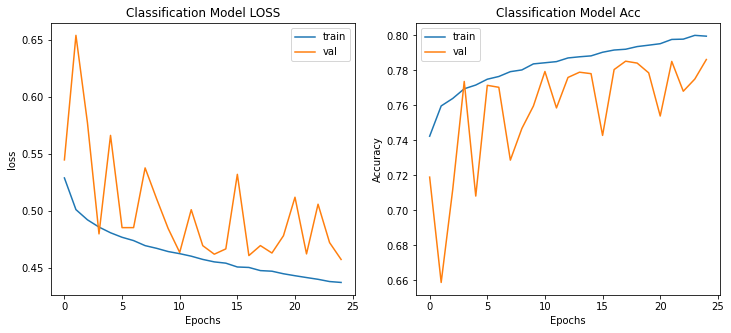

In [57]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(z.history['loss']);
plt.plot(z.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(z.history['accuracy']);
plt.plot(z.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

## Predictions

In [6]:
test_path = '../desktop/test/'

In [68]:
testdf = pd.DataFrame({'path': glob(os.path.join(test_path, '*.tif'))})
testdf['id'] = testdf.path.map(lambda x: ((x.split("/")[2].split('.')[0])[5:]))
testdf.head(3)

,path,id
0,../desktop/test\00006537328c33e284c973d7b39d34...,00006537328c33e284c973d7b39d340809f7271b
1,../desktop/test\0000ec92553fda4ce39889f9226ace...,0000ec92553fda4ce39889f9226ace43cae3364e
2,../desktop/test\00024a6dee61f12f7856b0fc6be20b...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2


In [26]:
with open('clf-resnet-model.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model1 = tf.keras.models.model_from_json(json_savedModel)
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               4718592   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                      

In [27]:
model1.load_weights('clf-resnet-weights.hdf5')

In [28]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               4718592   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                      

In [35]:
test_df = pd.read_csv('../desktop/sample_submission.csv')

from matplotlib.pyplot import imread
# Kaggle testing
from glob import glob
TESTING_BATCH_SIZE = 64
testing_files = glob(os.path.join('../desktop/test/','*.tif'))
submission = pd.DataFrame()
print(len(testing_files))
for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
    data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
    data_frame['id'] = data_frame.path.map(lambda x: ((x.split("/")[2].split('.')[0])[5:]))
    data_frame['image'] = data_frame['path'].map(imread)
    images = np.stack(data_frame.image, axis=0)
    predicted_labels = [model1.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
    predictions = np.array(predicted_labels)
    data_frame['label'] = predictions
    submission = pd.concat([submission, data_frame[["id", "label"]]])
    if index % 1000 == 0 :
        print(index/len(testing_files) * 100)
submission.to_csv('submission_new_model.csv', index=False, header=True)
print(submission.head())

57458
0.0
13.923213477670645
27.84642695534129
41.769640433011936
55.69285391068258
69.61606738835323
83.53928086602387
97.46249434369453
                                         id     label
0  00006537328c33e284c973d7b39d340809f7271b  0.605574
1  0000ec92553fda4ce39889f9226ace43cae3364e  0.585113
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2  0.632934
3  000253dfaa0be9d0d100283b22284ab2f6b643f6  0.731741
4  000270442cc15af719583a8172c87cd2bd9c7746  0.040566


In [36]:
submission.head(100)

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.605574
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.585113
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.632934
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.731741
4,000270442cc15af719583a8172c87cd2bd9c7746,0.040566
...,...,...
31,00694ecfbce48f346cda4d8cffd9a04dcac9e788,0.099596
32,006b80fa929adac3c111bfa47ee8bef69d3195c9,0.542987
33,006deda589bab5b4766d28f762a41e82194bfec7,0.655950
34,006f36c66eed831da677a6d468369095aa6c92f2,0.702060


In [18]:
submission.to_csv("submission.csv", index = False, header = True) #create the submission file

## Results and Analysis

Our models performed relatively as expected. The ResNet CNN performed much better than the baseline one. The ResNet model reached ~80% accuracy on the training set and the baseline reaached only ~41%. Trying a combination of "relu" and sigmoid as the output in the ResNet helped to improve accuracy, after all this is a binary classification problem, which sigmoid is made for. Looking at both the model loss and model accuracy graphs it appears our validation loss and accuracy was quite noisy for all 25 epochs, but did follow a general trend upwards for accuracy and downwards for loss. It could have been beneficial to run more than 25 epochs to continue the trend, but my computer unfortunately does not have a GPU, so the room for error and experimentation was small. Next time I would like to experiment with only 10,000 images using only a single value for the learning rate. The ResNet did well on the unseen test set on Kaggle, with a score of ~84%, surprisingly better than on the training set. For future iterations, performing some form of normalisation on the training and test images could prove to be very worthwhile.

## Conclusion

The biggest takeaway I have is that training a CNN requires a lot of experimentation to optimize it. There is no hard and fast way to create the perfect model. There are certainly ways I could have improved accuracy as I mentioned previously, such as normalizing the images (flipping to a certain orientation etc.). Changing activation functions certainly helped performance, as well as adding dense layers. I found the "adam" optimizer also produced the best results. Lastly I would like to have seen a confusion matrix for the test data. The ability to see how many false positives or false negatives would be valuable information to tweaking your model. The reason for that is because when dealing with medical data, in most cases you want to limit the number of false negatives as much as possible. Telling someone they do not have cancer when they do, is much worse than telling someone they do have cancer when they don't. That is the difference between a life being saved.

### Sources and Help

I borrowed greatly from these kernels and am grateful for their contributions.

https://www.kaggle.com/code/artgor/simple-eda-and-model-in-pytorch

https://www.kaggle.com/code/praxitelisk/histopathologic-cancer-detection-keras

https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb?scriptVersionId=7784920

https://www.kaggle.com/code/vbookshelf/cnn-how-to-use-160-000-images-without-crashing/notebook